In [60]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import zscore


In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/apollo/analysis_dataframes/cell_counts_time.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")
df['file_name'] = df['File'].str[-2:]
df.head()

df.shape=(1940, 12)


,File,Time,Red Only,Green Only,Both,Red Only Avg,Green Only Avg,Both Avg,P-Value,Significant,Timepoint Significant,Condition,file_name
0,cellsonlyD1,0.0,195.0,22.0,123.0,195.000000,22.000000,123.0,0.304514,False,False,cellsonly,D1
1,cellsonlyD1,1.0,213.0,21.0,111.0,204.000000,21.500000,117.0,0.304514,False,False,cellsonly,D1
2,cellsonlyD1,2.0,217.0,20.0,111.0,208.333333,21.000000,115.0,0.304514,False,False,cellsonly,D1
3,cellsonlyD1,3.0,217.0,20.0,114.0,215.666667,20.333333,112.0,0.304514,False,False,cellsonly,D1
4,cellsonlyD1,4.0,225.0,20.0,108.0,219.666667,20.000000,111.0,0.304514,False,False,cellsonly,D1


# filtering

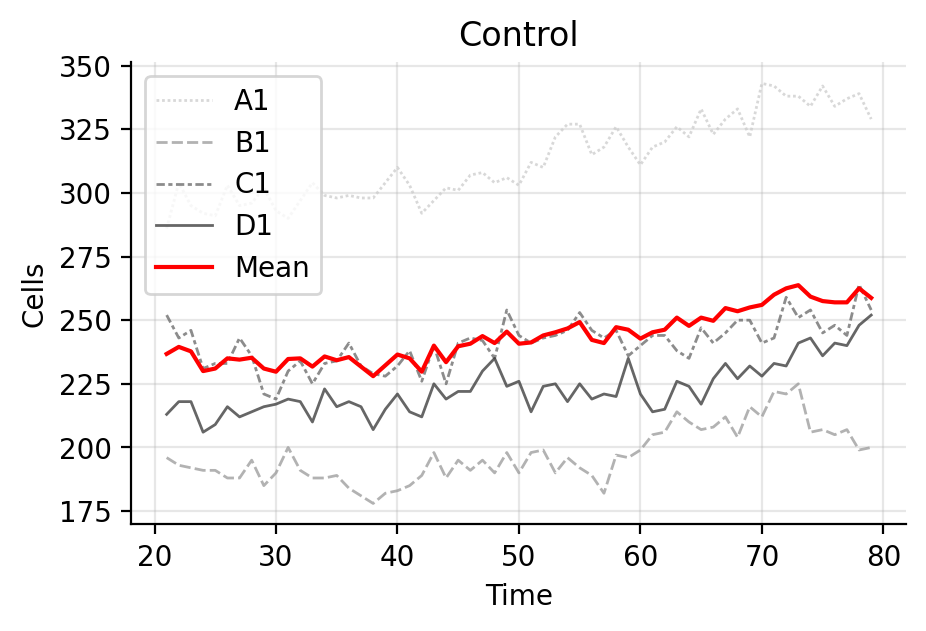

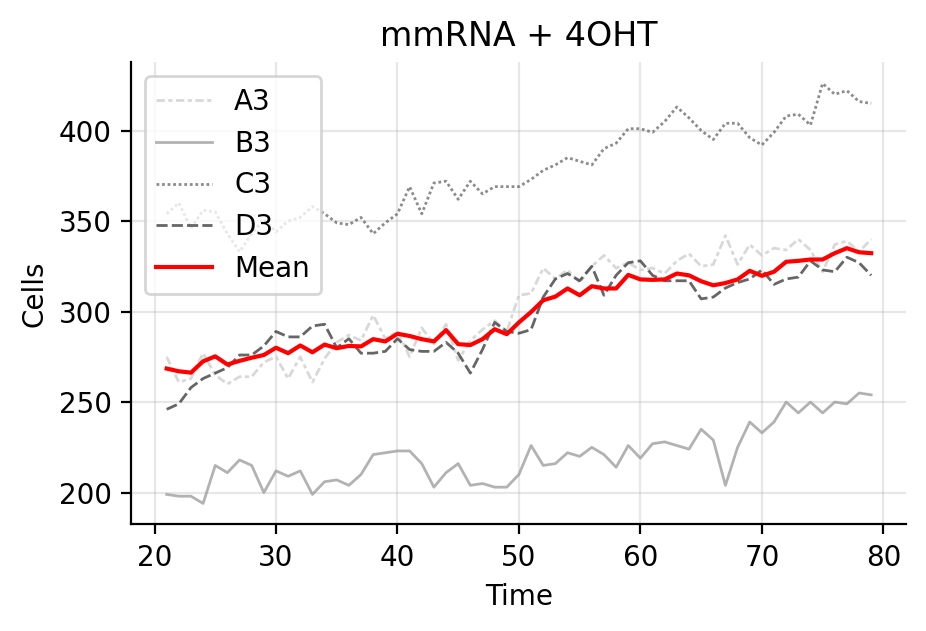

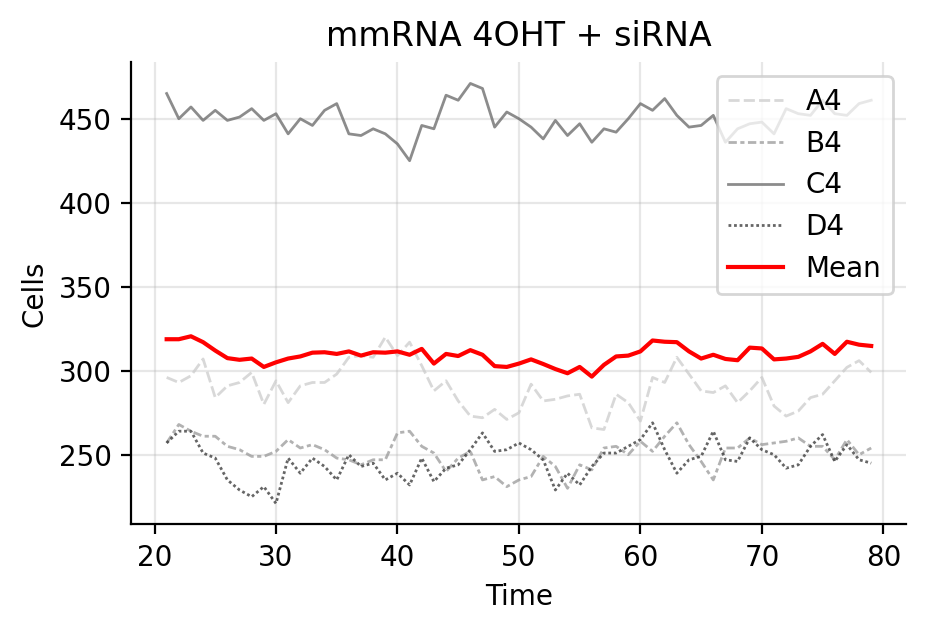

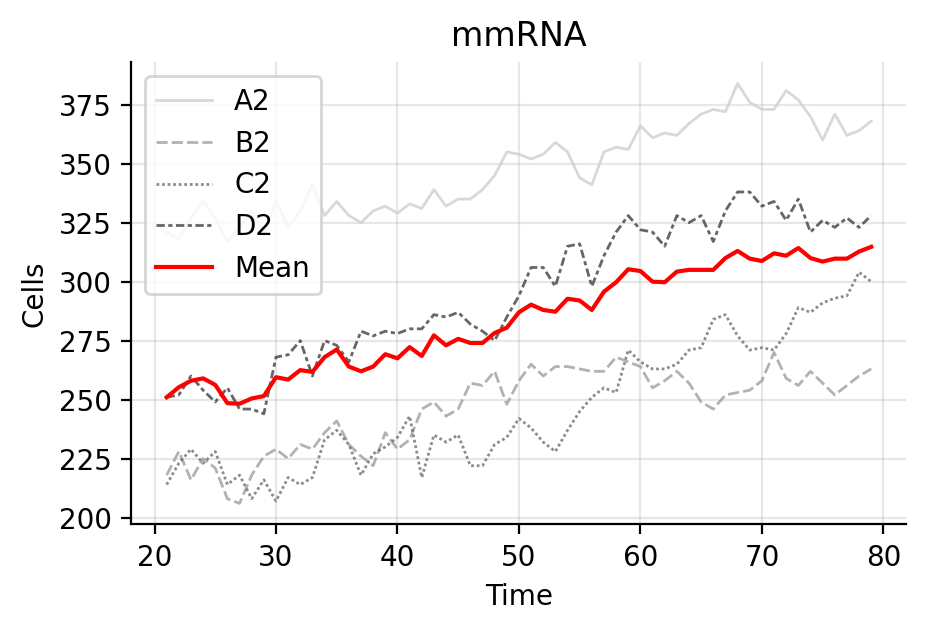

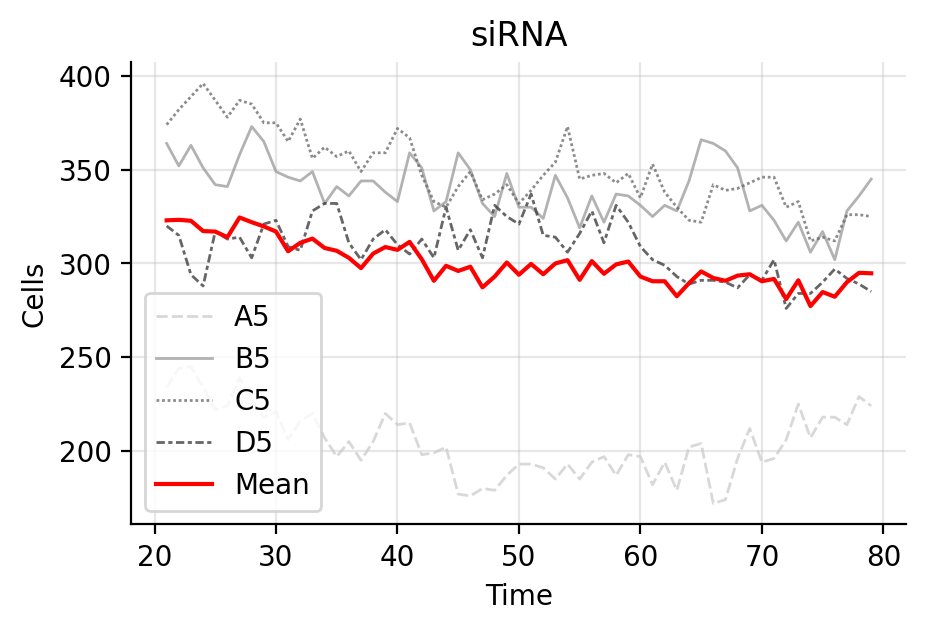

In [65]:
pdf = df.copy()
pdf = pdf[(pdf['Time'] < 80) & (pdf['Time'] > 20)]

title_map = {
    'cellsonly': 'Control',
    'mmRNAonly': 'mmRNA',
    'siRNAonly': 'siRNA',
    'mmRNA4OHTsiRNA': 'mmRNA 4OHT + siRNA',
    'mmRNA4OHT': 'mmRNA + 4OHT'
}

results = []

for condition, group in pdf.groupby('Condition'):
    
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 5, 3
    
    ax = sns.lineplot(
        group,
        x='Time',
        y='Red Only',
        hue='file_name', 
        style='file_name',
        hue_order=sorted(group['file_name'].unique()),
        # marker=".",
        lw=1,
        palette='binary',
        zorder=2,
        alpha=0.75,
    )
    
    # Calculate and plot the average line
    avg_line = group.groupby('Time')['Red Only'].mean()
    row = avg_line.reset_index()
    row['red_zscore'] = zscore(row['Red Only'].values)
    row['condition'] = condition
    results.append(row)
    

    ax.plot(
        avg_line.index, 
        avg_line.values, 
        color='r', 
        label='Mean',
    )

    # Add grid lines
    ax.grid(True, alpha=0.3, zorder=0)
    
    plt.legend()
    
    sns.move_legend(
        ax,
        title="",
        loc='best',
    )
    
    plt.ylabel("Cells")
    plt.xlabel("Time")
    plt.title(title_map[condition])
    sns.despine()
    
    plt.show()

['Control', 'mmRNA', 'mmRNA + 4OHT', 'mmRNA 4OHT + siRNA', 'siRNA']


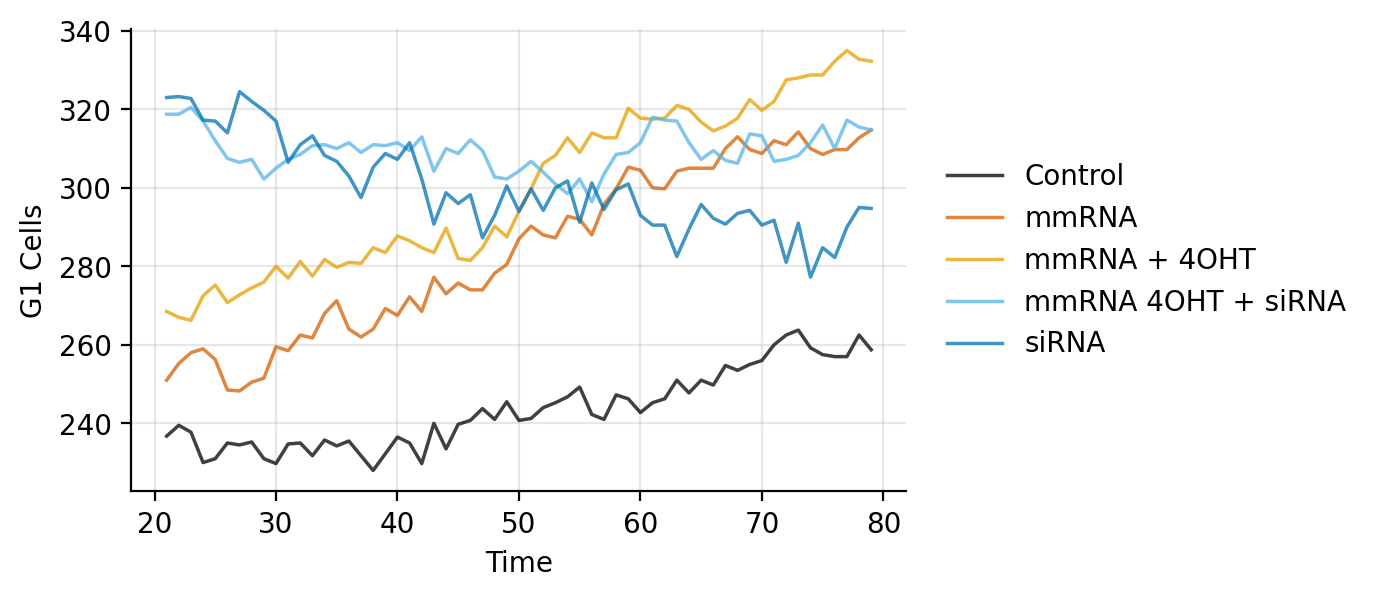

In [80]:
result_df = pd.concat(results, ignore_index=True)
result_df['label'] = result_df['condition'].map(title_map)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

print(sorted(result_df['label'].unique()))

hex_codes = [
    'k',  # cellsonly: Control (dark blue)
    '#D55E00',  # mmRNAonly: mmRNA (orange) 
    '#E69F00',  # mmRNA4OHT: mmRNA + 4OHT (light blue) 
    '#56B4E9',  # mmRNA4OHTsiRNA: mmRNA 4OHT + siRNA (vermilion)
    '#0072B2',  # siRNAonly: siRNA (green)
]


ax = sns.lineplot(
    result_df,
    x='Time',
    y='Red Only',
    hue='label', 
    hue_order=sorted(result_df['label'].unique()),
    # marker=".",
    lw=1.25,
    palette=hex_codes,
    zorder=2,
    alpha=0.75,
)

# Add grid lines
ax.grid(True, alpha=0.3, zorder=0)

sns.move_legend(
    ax,
    title="",
    loc='center right',
    frameon=False,
    bbox_to_anchor=(1.6, 0.5),
)

plt.ylabel("G1 Cells")
plt.xlabel("Time")
sns.despine()

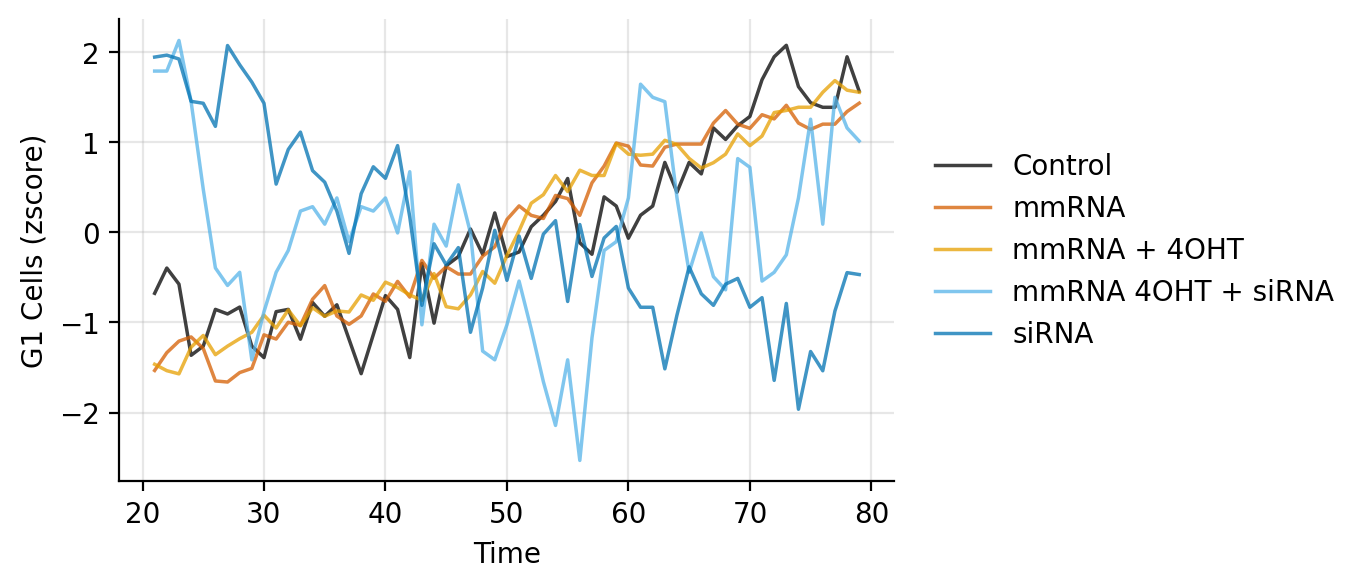

In [81]:
result_df = pd.concat(results, ignore_index=True)
result_df['label'] = result_df['condition'].map(title_map)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

ax = sns.lineplot(
    result_df,
    x='Time',
    y='red_zscore',
    hue='label', 
    hue_order=sorted(result_df['label'].unique()),
    # marker=".",
    lw=1.25,
    palette=hex_codes,
    zorder=2,
    alpha=0.75,
)

# Add grid lines
ax.grid(True, alpha=0.3, zorder=0)

sns.move_legend(
    ax,
    title="",
    loc='center right',
    frameon=False,
    bbox_to_anchor=(1.6, 0.5),
)

plt.ylabel("G1 Cells (zscore)")
plt.xlabel("Time")
sns.despine()

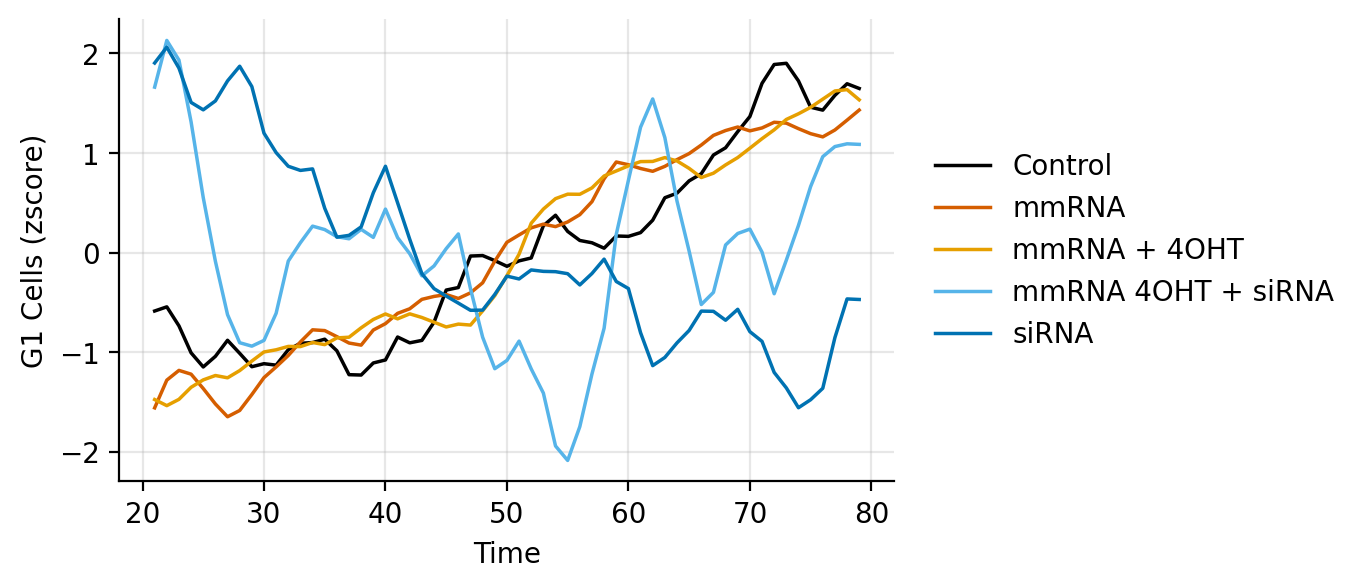

In [82]:

def smooth_signal(df, window_length=10):
    df['smoothed_red'] = df.groupby('label')['red_zscore'].transform(lambda x: savgol_filter(x, window_length=window_length, polyorder=3))
    return df

# Apply the smoothing function to your DataFrame
result_df2 = smooth_signal(result_df, 7)
result_df2.head()


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

ax = sns.lineplot(
    result_df2,
    x='Time',
    y='smoothed_red',
    hue='label', 
    hue_order=sorted(result_df['label'].unique()),
    # marker=".",
    lw=1.25,    
    palette=hex_codes,
    zorder=2,
)

# Add grid lines
ax.grid(True, alpha=0.3, zorder=0)


sns.move_legend(
    ax,
    title="",
    loc='center right',
    frameon=False,
    bbox_to_anchor=(1.6, 0.5),
)

plt.ylabel("G1 Cells (zscore)")
plt.xlabel("Time")
sns.despine()

In [4]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
list(df['Condition'].unique())

In [ ]:
sns.lineplot(
    pdf,
    x='Time',
    y='Red Only',
    hue='Condition',
)